<a target="_blank" rel="noopener" href="https://colab.research.google.com/github/bizzyvinci/Gitcoin-grant-round-analysis/blob/main/analysis.ipynb">
    <img alt="Open in Colab" src="https://camo.githubusercontent.com/84f0493939e0c4de4e6dbe113251b4bfb5353e57134ffd9fcab6b8714514d4d1/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667" />
</a>

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_dir = Path('.')
data_dir

PosixPath('.')

In [3]:
# data.csv is the first sheet in this google sheet
# https://docs.google.com/spreadsheets/d/1OsJ_nmN9mN-i_9h3Yj2mDfjvtsP1qvv3B1zcpER62dk/edit#gid=1223173410
df = pd.read_csv(data_dir/'data.csv', parse_dates=['round_start_date', 'round_end_date'])
print(df.shape)
df.head()

(5906, 13)


,round_number,round_start_date,round_end_date,grant_title,grant_id,region,category,url,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total
0,12,2021-12-01,2021-12-16,Coin Center is educating policy makers about p...,1668,north_america,Community,https://gitcoin.co/grants/1668/coin-center-is-...,"$340,000.00",6914,5727,"$103,838.93","$443,838.93"
1,12,2021-12-01,2021-12-16,Electronic Frontier Foundation,3974,north_america,Community,https://gitcoin.co/grants/3974/electronic-fron...,"$228,273.84",3648,3331,"$58,715.04","$286,988.88"
2,12,2021-12-01,2021-12-16,The Tor Project,2805,undefined,Infra Tech,https://gitcoin.co/grants/2805/the-tor-project,"$188,294.80",3497,3069,"$95,279.64","$283,574.44"
3,12,2021-12-01,2021-12-16,Longevity Prize (by VitaDAO),4083,europe,Grants Round 12,https://gitcoin.co/grants/4083/longevity-prize...,"$176,195.45",920,857,"$7,815.29","$184,010.75"
4,12,2021-12-01,2021-12-16,Rotki - The portfolio tracker and accounting t...,149,europe,dApp Tech,https://gitcoin.co/grants/149/rotki-the-portfo...,"$129,131.34",4684,4311,"$25,373.62","$154,504.96"


### Clean

In [4]:
def usd_to_int(x):
    return float(re.sub('[$,]', '', str(x)))

usd_to_int('$129,131.34')

129131.34

In [5]:
usd_cols = ['match_amount', 'crowdfund_amount_contributions_usd', 'total']
df[usd_cols] = df[usd_cols].applymap(usd_to_int)

# Fillna
df['region'].fillna('undefined', inplace=True)
df.fillna(0, inplace=True)

df.head()

,round_number,round_start_date,round_end_date,grant_title,grant_id,region,category,url,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total
0,12,2021-12-01,2021-12-16,Coin Center is educating policy makers about p...,1668,north_america,Community,https://gitcoin.co/grants/1668/coin-center-is-...,340000.00,6914,5727,103838.93,443838.93
1,12,2021-12-01,2021-12-16,Electronic Frontier Foundation,3974,north_america,Community,https://gitcoin.co/grants/3974/electronic-fron...,228273.84,3648,3331,58715.04,286988.88
2,12,2021-12-01,2021-12-16,The Tor Project,2805,undefined,Infra Tech,https://gitcoin.co/grants/2805/the-tor-project,188294.80,3497,3069,95279.64,283574.44
3,12,2021-12-01,2021-12-16,Longevity Prize (by VitaDAO),4083,europe,Grants Round 12,https://gitcoin.co/grants/4083/longevity-prize...,176195.45,920,857,7815.29,184010.75
4,12,2021-12-01,2021-12-16,Rotki - The portfolio tracker and accounting t...,149,europe,dApp Tech,https://gitcoin.co/grants/149/rotki-the-portfo...,129131.34,4684,4311,25373.62,154504.96


### Info

In [6]:
#df.info()

In [7]:
#df.describe(datetime_is_numeric=True)

## Grant Rounds Analysis

### Grant rounds

Just view how values such as `total`, `contributions` etc has increased over the grants. I added another column which the average of total.

In [8]:
round_cols = ['round_number', 'round_start_date', 'round_end_date']
round_df = df[round_cols].drop_duplicates(ignore_index=True)
round_df['round_duration'] = (round_df['round_end_date'] - round_df['round_start_date']).astype('timedelta64[D]')
round_df = round_df.set_index('round_number', drop=True)
round_df['no_of_grants'] = df.groupby('round_number').count()['round_start_date']
contributions = df.groupby('round_number').sum().drop('grant_id', axis=1)
round_df = round_df.join(contributions)
round_df['total_per_grant'] = round_df['total'] / round_df['no_of_grants']
round_df

,round_start_date,round_end_date,round_duration,no_of_grants,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total,total_per_grant
round_number,,,,,,,,,,
12,2021-12-01,2021-12-16,15.0,1812,3090569.14,421019,356895,2938955.53,6029524.56,3327.552185
11,2021-09-08,2021-09-24,16.0,877,929755.27,385780,340871,1360270.46,2290025.89,2611.203979
10,2021-06-16,2021-07-02,16.0,723,694491.13,270411,235877,1039014.22,1733505.44,2397.656210
9,2021-03-10,2021-03-25,15.0,654,520743.73,148983,118994,1116601.22,1637344.74,2503.585229
8,2020-12-01,2020-12-18,17.0,371,349912.25,91396,20122,2081178.35,2431090.69,6552.805094
7,2020-09-14,2020-10-02,18.0,291,441160.55,12334,10791,277940.89,719101.55,2471.139347
6,2020-06-16,2020-07-03,17.0,607,171638.67,8323,7604,183527.84,355166.61,585.117974
5,2020-03-23,2020-04-05,13.0,292,244388.00,5353,4993,89817.33,334205.34,1144.538836
4,2020-01-06,2020-01-21,15.0,152,153553.90,4806,4481,102619.19,256173.09,1685.349276


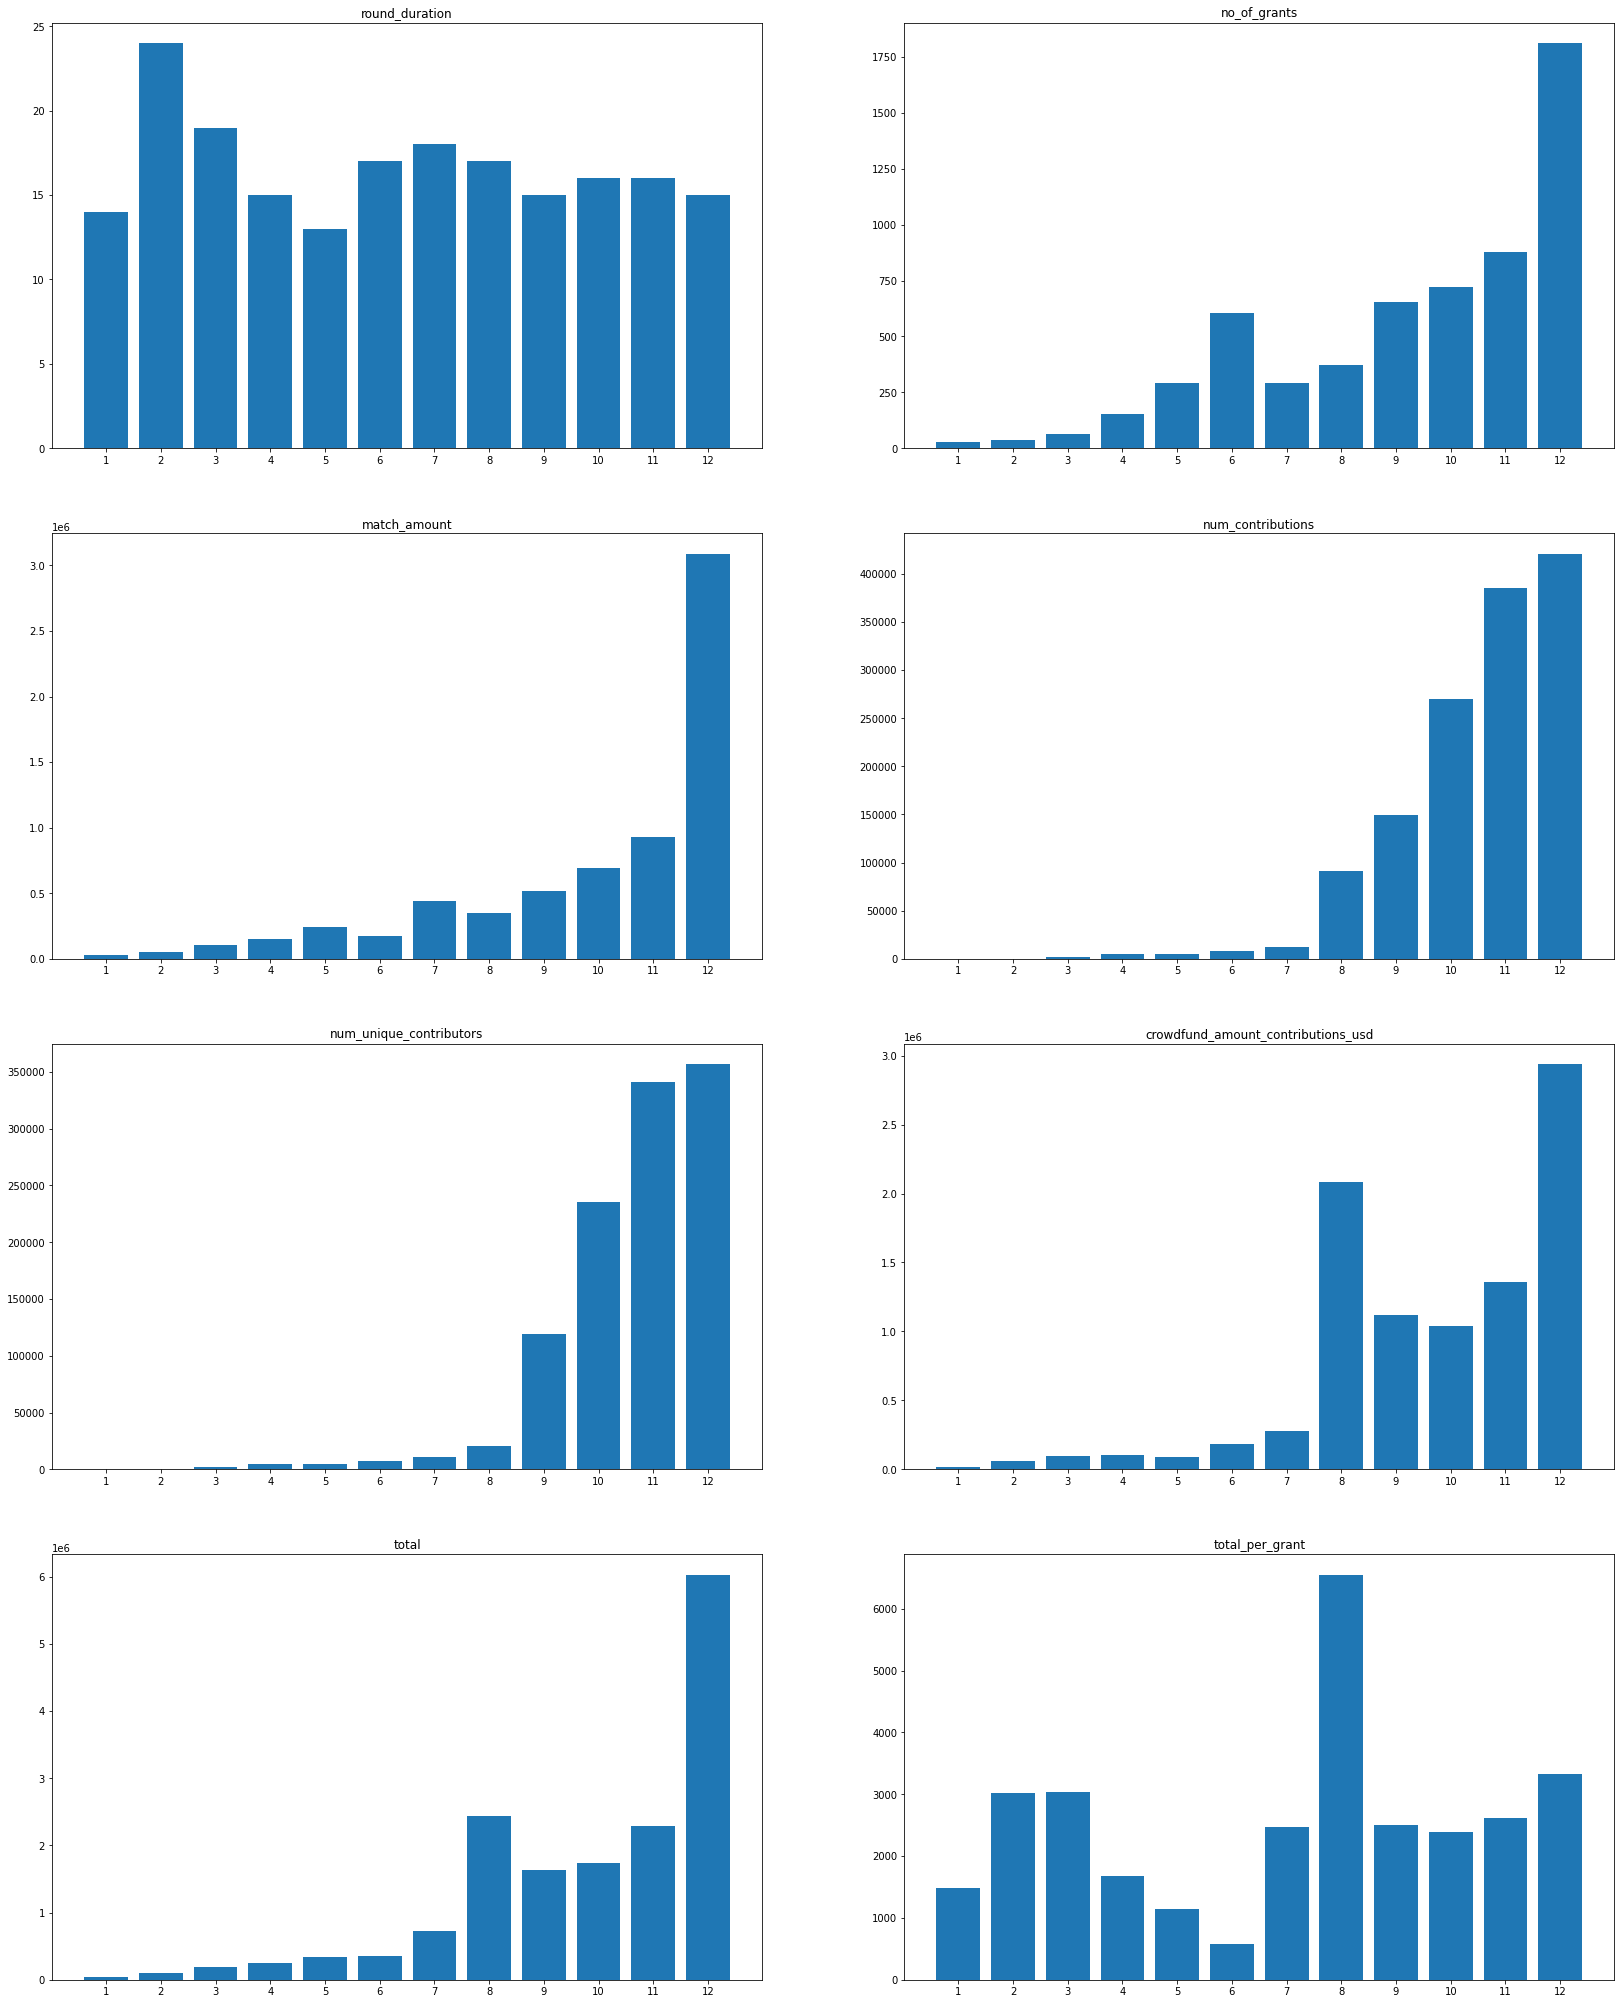

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(28, 36))
for i in range(8):
    #axs[i//2, i%2].plot(round_df.iloc[:, i+2], '-o')
    axs[i//2, i%2].bar(round_df.index, round_df.iloc[:, i+2])
    axs[i//2, i%2].set_title(round_df.columns[i+2])
    axs[i//2, i%2].set_xticks(round_df.index)

It's interesting to see everything has been growing from `GR1` to `GR12` such as number of grants, match amount and contributions. A little change in trend is a spike in `GR8`, as there were more crowdfund contributions and therefore the peak for the average total amount contributed to grants. Crownfund contribution in `GR8` is spectacular and it proves the importance of `crowdfund_amount_contributions_usd`.

EDIT: Later discovered that the big contributions in GR8 flowed to some big projects mainly from `north_america` and `undefined` location.

### Round vs Category and Round vs Region

View how categories and regions have evolved over the grants.

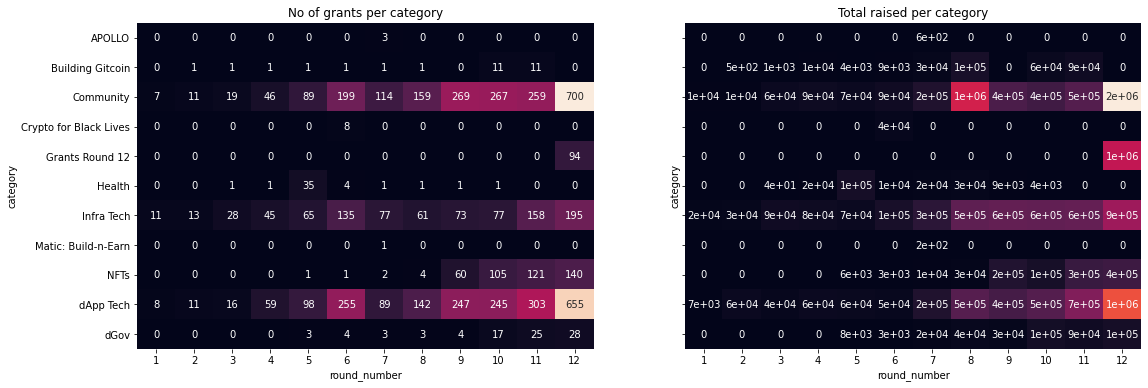

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(18,6))

categories = df.groupby(['round_number', 'category']).count()['total'].unstack(level=0, fill_value=0)
sns.heatmap(categories, annot=True, fmt='', cbar=False, ax=ax1)
ax1.set_title('No of grants per category')

categories = df.groupby(['round_number', 'category']).sum()['total'].unstack(level=0, fill_value=0)
sns.heatmap(categories, annot=True, fmt='.1g', cbar=False, ax=ax2)
ax2.set_title('Total raised per category')

plt.show()


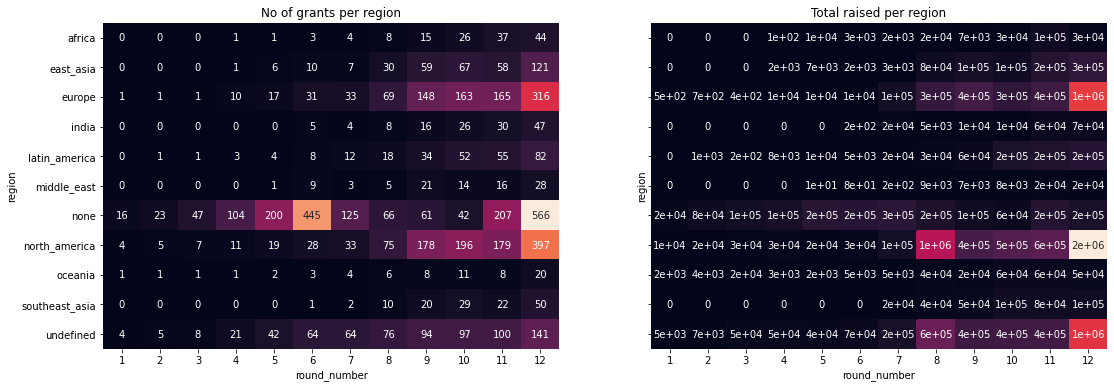

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(18,6))

regions = df.groupby(['round_number', 'region']).count()['total'].unstack(level=0, fill_value=0)
sns.heatmap(regions, annot=True, fmt='', cbar=False, ax=ax1)
ax1.set_title('No of grants per region')

regions = df.groupby(['round_number', 'region']).sum()['total'].unstack(level=0, fill_value=0)
sns.heatmap(regions, annot=True, fmt='.1g', cbar=False, ax=ax2)
ax2.set_title('Total raised per region')

plt.show()


From the heatmap above, funds seem well distributed between various categories and regions. The categories or regions with more grants, had more total funding. The exception is `none` region (a lot of grants but less fund) and I don't know why. A look at match_amount (instead of total) has similar pattern. So I guess there's little to no worry about some regions/categories getting underfunded because of popularity.

In `GR8`, it could be noticed that `north_america` and `undefined` has more grants but still a much larger contributions. The top projects with contribution in `GR8` is below.

In [12]:
df[(df['round_number']==8)].sort_values('crowdfund_amount_contributions_usd', ascending=False).head(10)

,round_number,round_start_date,round_end_date,grant_title,grant_id,region,category,url,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total
4066,8,2020-12-01,2020-12-18,Coin Center is educating policy makers about p...,1668,north_america,Community,https://gitcoin.co/grants/1668/coin-center-is-...,21413.12,1344,311,652919.46,674332.58
4067,8,2020-12-01,2020-12-18,Hardhat by Nomic Labs,1592,undefined,dApp Tech,https://gitcoin.co/grants/1592/hardhat-by-nomi...,3986.07,652,159,150428.39,154414.45
4068,8,2020-12-01,2020-12-18,Gitcoin Grants Core Team - Dev Fund,86,north_america,Building Gitcoin,https://gitcoin.co/grants/86/gitcoin-grants-co...,3451.84,22240,3994,138626.64,142078.48
4069,8,2020-12-01,2020-12-18,OpenEthereum (Ex-Parity client),1415,undefined,Infra Tech,https://gitcoin.co/grants/1415/openethereum-ex...,6033.25,752,179,52112.68,58145.94
4070,8,2020-12-01,2020-12-18,Nimbus,137,undefined,Infra Tech,https://gitcoin.co/grants/137/nimbus,5057.28,820,187,44622.57,49679.86
4071,8,2020-12-01,2020-12-18,Gitcoin Grants Official Matching Pool Fund,12,north_america,Infra Tech,https://gitcoin.co/grants/12/gitcoin-grants-of...,4405.89,704,169,43016.59,47422.47
4072,8,2020-12-01,2020-12-18,Circles UBI,331,undefined,Infra Tech,https://gitcoin.co/grants/331/circles-ubi,3511.53,524,123,41928.48,45440.02
4074,8,2020-12-01,2020-12-18,Fiona Kobayashi - Software Engineer,294,undefined,Community,https://gitcoin.co/grants/294/fiona-kobayashi-...,160.71,160,36,40638.20,40798.92
4075,8,2020-12-01,2020-12-18,EU Crypto Initiative - educating policy makers...,1693,europe,Community,https://gitcoin.co/grants/1693/eu-crypto-initi...,75.69,100,23,39534.55,39610.24
4073,8,2020-12-01,2020-12-18,Prysm by Prysmatic Labs,24,north_america,Infra Tech,https://gitcoin.co/grants/24/prysm-by-prysmati...,6682.31,900,213,34867.48,41549.79


### Word clouds

This is to have an overview of how vocabulary has evolved over the years. What are the buzzwords or trending project in a grant round?

In [13]:
from wordcloud import WordCloud, STOPWORDS

In [14]:
stopwords = set(STOPWORDS)
def get_wordcloud(round):
    words = ''
    for val in df[df['round_number']==round]['grant_title']:
        words += val.lower() + ' '
    wordcloud = WordCloud(stopwords=stopwords, min_font_size=3,
                          width=1600, height=800,
                          ).generate(words)
    return wordcloud

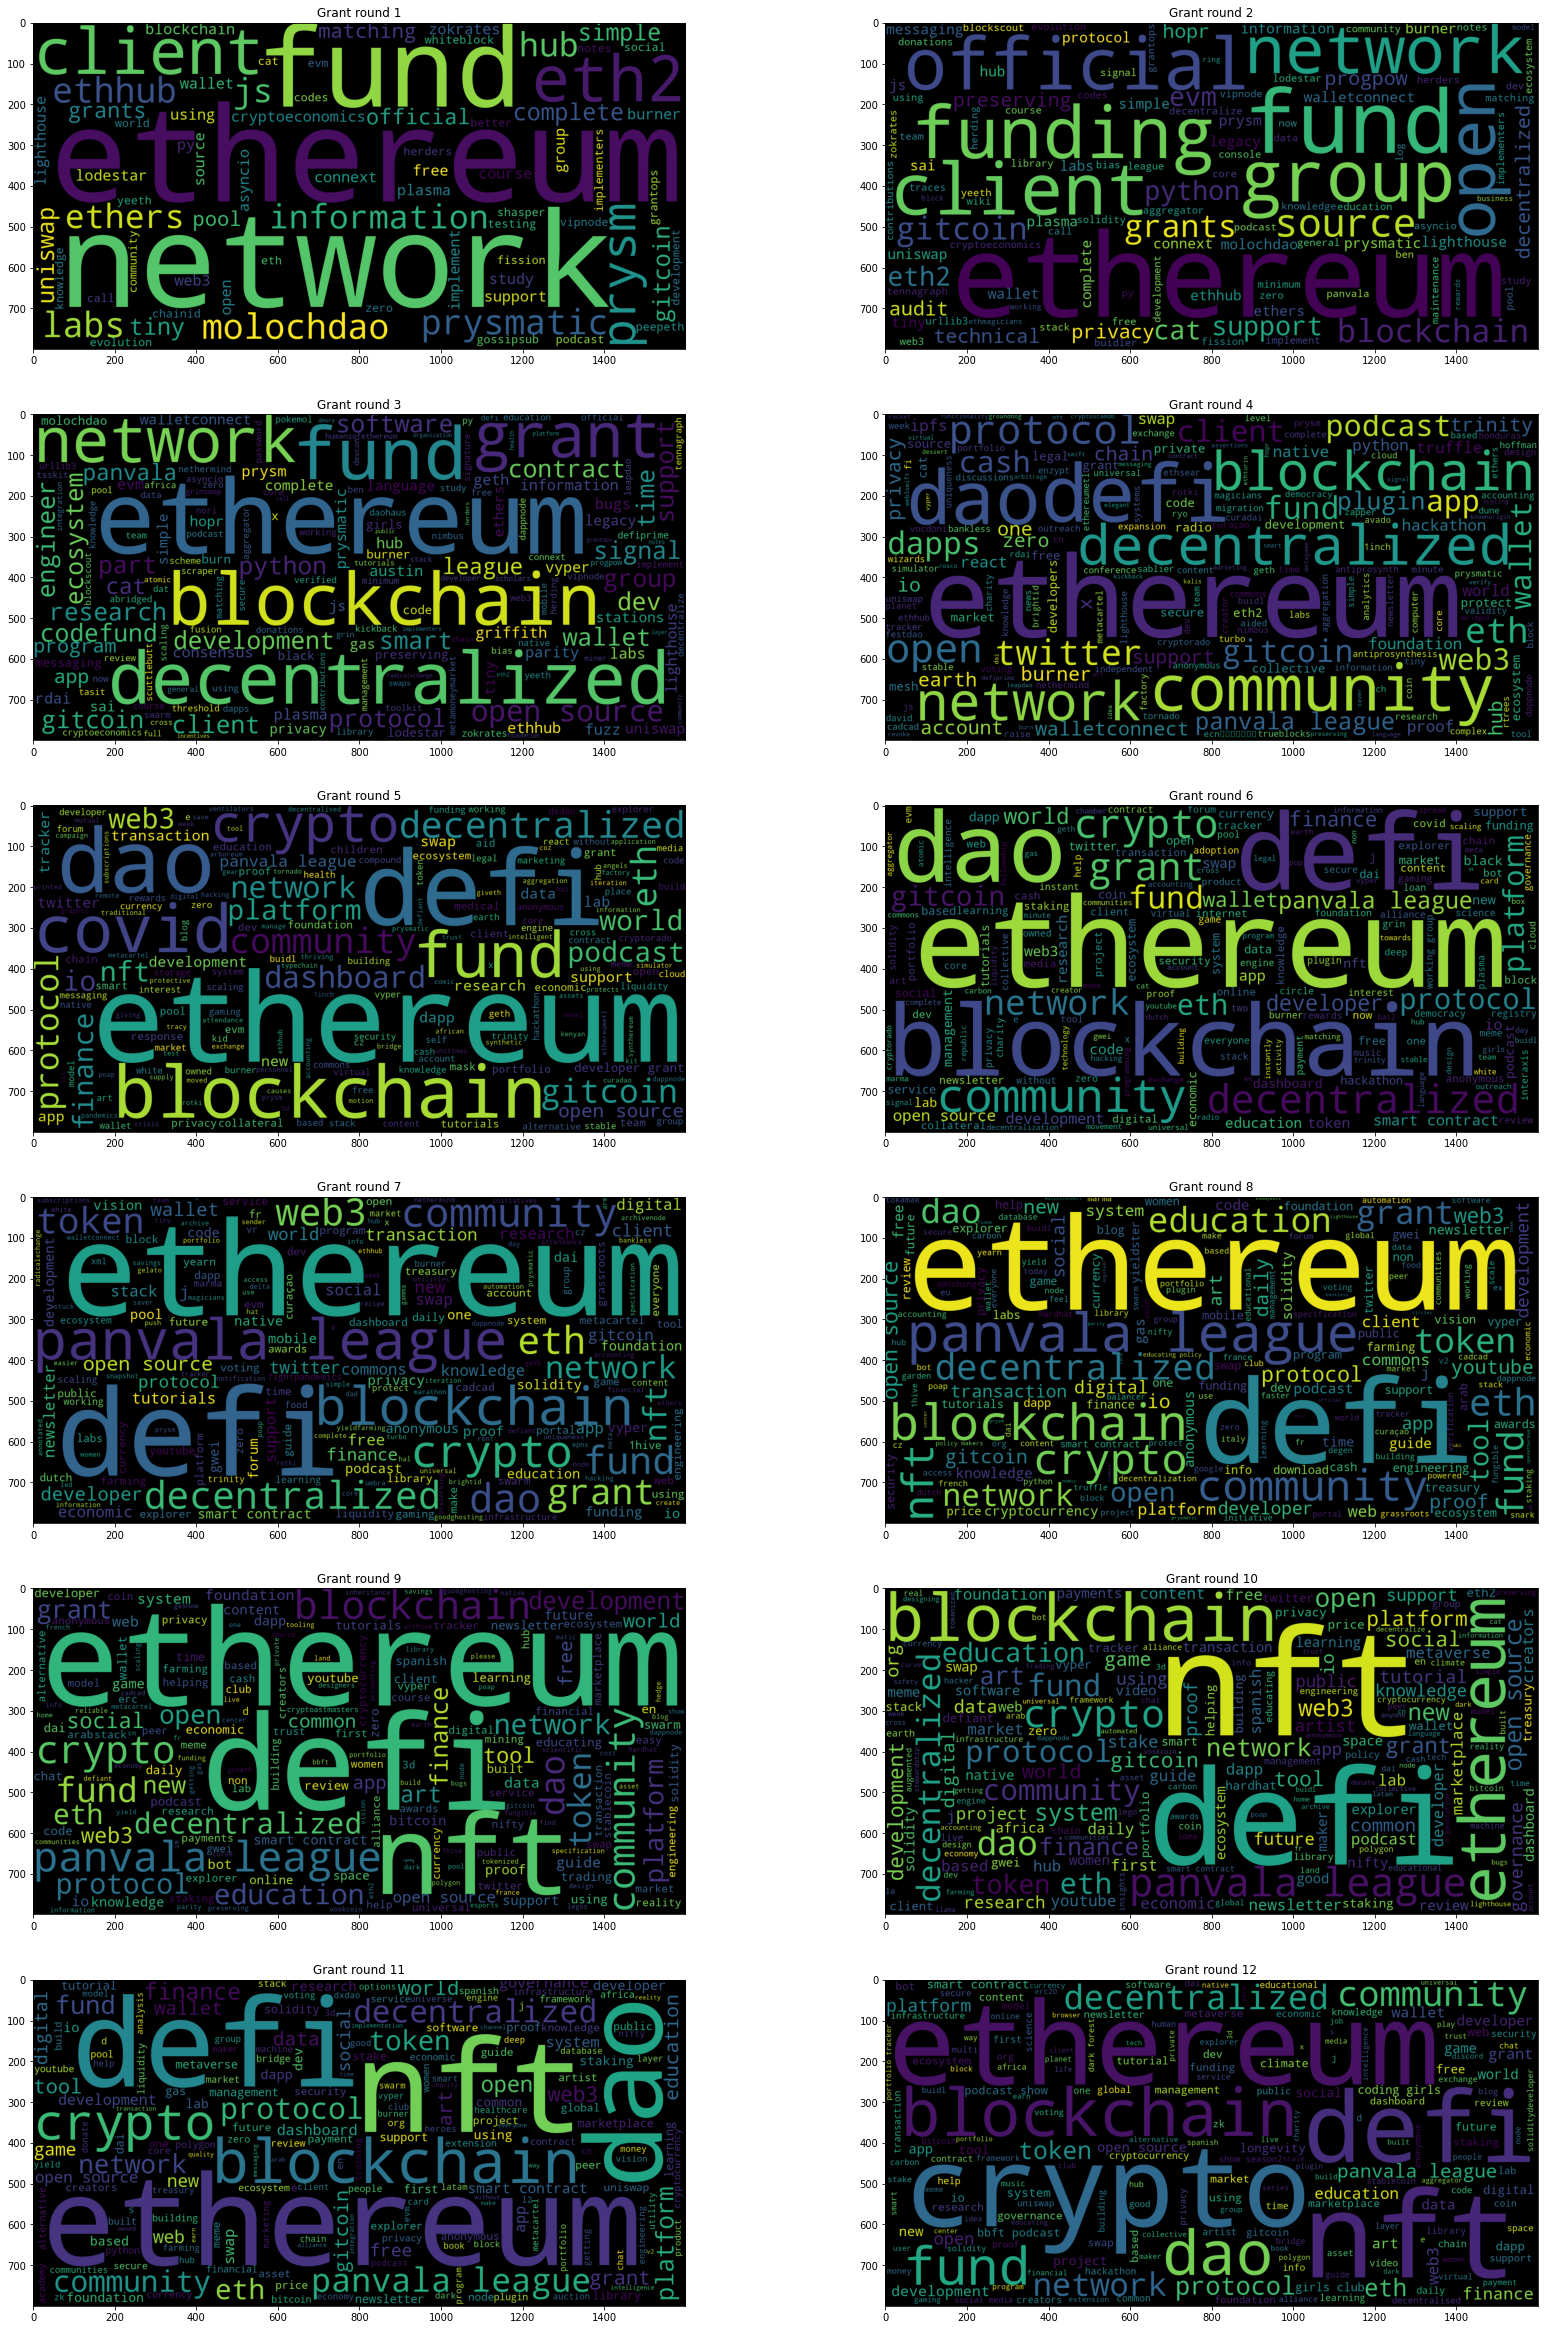

In [15]:
fig, axs = plt.subplots(6, 2, figsize=(28, 42))
for i in range(12):
    round = i+1
    axs[i//2, i%2].imshow(get_wordcloud(round))
    axs[i//2, i%2].set_title(f"Grant round {round}")

Hmm. This is a nice ethereum community.

## QF vs CLF

While investigating `GR12` (QF), I thought it would be a great idea to compare with `GR11 & GR10` as CLF. They are recent and the number of grants is `1600` (close to 1812 for GR12).

There's a discovery which I think is concerning. Although funds were distributed well among various categories and regions, a large amount of grants had zero unique contributors and zero funds raised (match or contributed) in `GR12`. 

This was a concerned raised on [gov.gitcoin](https://gov.gitcoin.co/t/proposal-gitcoin-gr12-matching-pool-allocations/9007/2).

But how did such a large amount of grants had 0 contributors?

In [16]:
qf_df = df[df['round_number'] == 12]
clf_df = df[(df['round_number'] == 11) | (df['round_number'] == 10)]
print('QF shape', qf_df.shape)
print('CLF shape', clf_df.shape)

QF shape (1812, 13)
CLF shape (1600, 13)


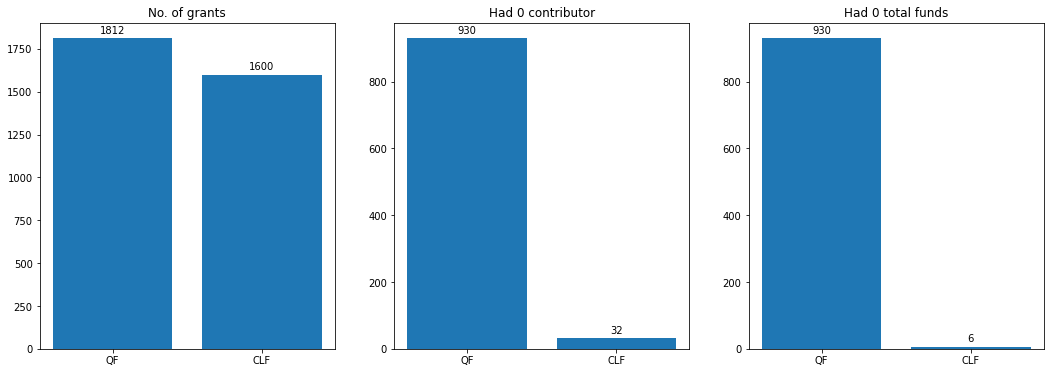

In [17]:
x = ['QF', 'CLF']
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))

def plot_bar(ax, y, title=None):
    pps = ax.bar(x, y)
    ax.set_title(title)
    # copied from https://www.tutorialspoint.com/adding-value-labels-on-a-matplotlib-bar-chart
    for p in pps:
        height = p.get_height()
        ax.annotate('{}'.format(height),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')

y = [qf_df.shape[0], clf_df.shape[0]]
plot_bar(ax1, y, "No. of grants")

y = [qf_df[qf_df['num_unique_contributors']==0].shape[0], clf_df[clf_df['num_unique_contributors']==0].shape[0]]
plot_bar(ax2, y, "Had 0 contributor")

y = [qf_df[qf_df['total']==0].shape[0], clf_df[clf_df['total']==0].shape[0]]
plot_bar(ax3, y, "Had 0 total funds")


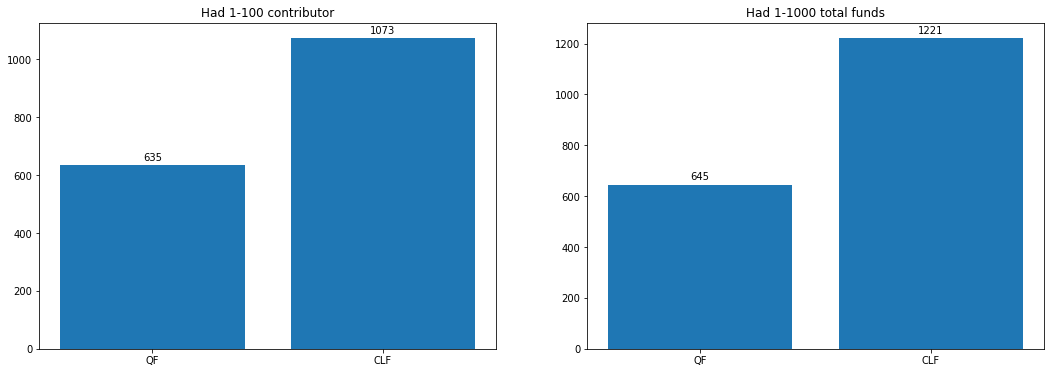

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))

y = [
     qf_df[(qf_df['num_unique_contributors']>0) & (qf_df['num_unique_contributors']<=100)].shape[0], 
     clf_df[(clf_df['num_unique_contributors']>0) & (clf_df['num_unique_contributors']<=100)].shape[0]
]
plot_bar(ax1, y, "Had 1-100 contributor")

y = [
     qf_df[(qf_df['total']>0) & (qf_df['total']<=1000)].shape[0], 
     clf_df[(clf_df['total']>0) & (clf_df['total']<=1000)].shape[0]
]
plot_bar(ax2, y, "Had 1-1000 total funds")


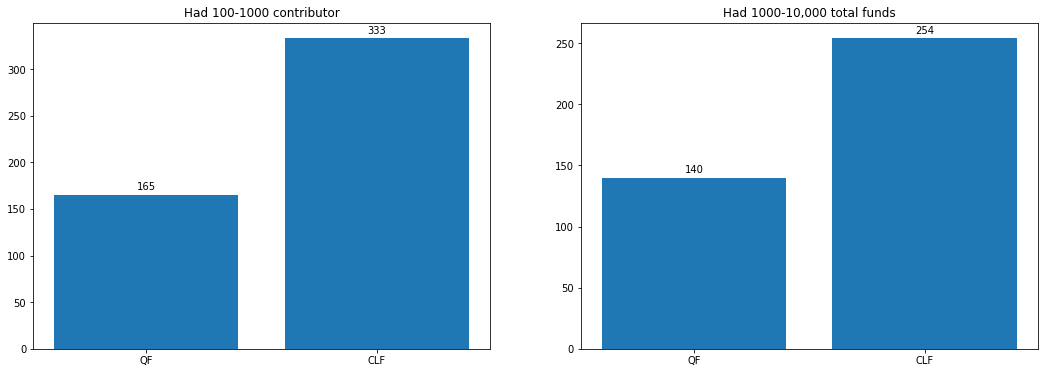

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))

y = [
     qf_df[(qf_df['num_unique_contributors']>100) & (qf_df['num_unique_contributors']<=1000)].shape[0], 
     clf_df[(clf_df['num_unique_contributors']>100) & (clf_df['num_unique_contributors']<=1000)].shape[0]
]
plot_bar(ax1, y, "Had 100-1000 contributor")

y = [
     qf_df[(qf_df['total']>1000) & (qf_df['total']<=10_000)].shape[0], 
     clf_df[(clf_df['total']>1000) & (clf_df['total']<=10_000)].shape[0]
]
plot_bar(ax2, y, "Had 1000-10,000 total funds")


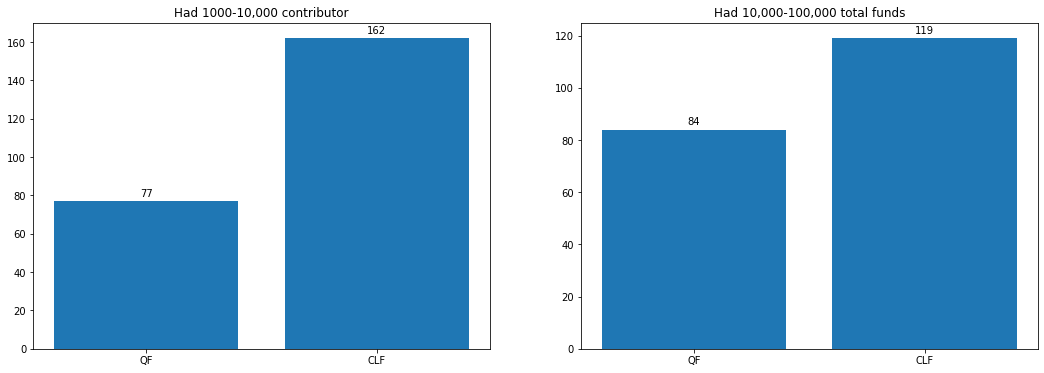

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))

y = [
     qf_df[(qf_df['num_unique_contributors']>1000) & (qf_df['num_unique_contributors']<=10_000)].shape[0], 
     clf_df[(clf_df['num_unique_contributors']>1000) & (clf_df['num_unique_contributors']<=10_000)].shape[0]
]
plot_bar(ax1, y, "Had 1000-10,000 contributor")

y = [
     qf_df[(qf_df['total']>10_000) & (qf_df['total']<=100_000)].shape[0], 
     clf_df[(clf_df['total']>10_000) & (clf_df['total']<=100_000)].shape[0]
]
plot_bar(ax2, y, "Had 10,000-100,000 total funds")


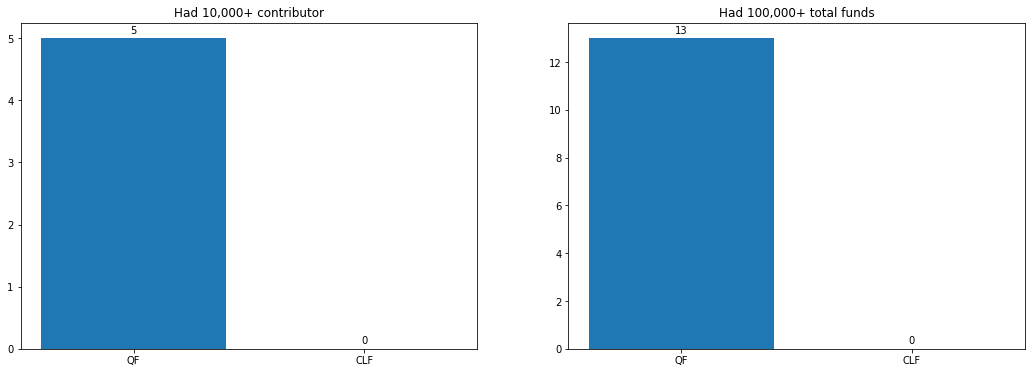

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))

y = [
     qf_df[qf_df['num_unique_contributors']>10_000].shape[0], 
     clf_df[clf_df['num_unique_contributors']>10_000].shape[0]
]
plot_bar(ax1, y, "Had 10,000+ contributor")

y = [
     qf_df[qf_df['total']>100_000].shape[0], 
     clf_df[clf_df['total']>100_000].shape[0]
]
plot_bar(ax2, y, "Had 100,000+ total funds")


In [22]:
df.sort_values('match_amount', ascending=False).head(10)

,round_number,round_start_date,round_end_date,grant_title,grant_id,region,category,url,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total
0,12,2021-12-01,2021-12-16,Coin Center is educating policy makers about p...,1668,north_america,Community,https://gitcoin.co/grants/1668/coin-center-is-...,340000.00,6914,5727,103838.93,443838.93
1,12,2021-12-01,2021-12-16,Electronic Frontier Foundation,3974,north_america,Community,https://gitcoin.co/grants/3974/electronic-fron...,228273.84,3648,3331,58715.04,286988.88
2,12,2021-12-01,2021-12-16,The Tor Project,2805,undefined,Infra Tech,https://gitcoin.co/grants/2805/the-tor-project,188294.80,3497,3069,95279.64,283574.44
3,12,2021-12-01,2021-12-16,Longevity Prize (by VitaDAO),4083,europe,Grants Round 12,https://gitcoin.co/grants/4083/longevity-prize...,176195.45,920,857,7815.29,184010.75
4,12,2021-12-01,2021-12-16,Rotki - The portfolio tracker and accounting t...,149,europe,dApp Tech,https://gitcoin.co/grants/149/rotki-the-portfo...,129131.34,4684,4311,25373.62,154504.96
5,12,2021-12-01,2021-12-16,The Blockchain Association (BA),4118,north_america,Grants Round 12,https://gitcoin.co/grants/4118/the-blockchain-...,95412.84,2526,2295,59139.18,154552.02
6,12,2021-12-01,2021-12-16,Kick-starting the market for future carbon,4119,north_america,Grants Round 12,https://gitcoin.co/grants/4119/kick-starting-t...,81902.00,1365,1252,33099.17,115001.17
7,12,2021-12-01,2021-12-16,ZigZag Exchange,4352,undefined,Grants Round 12,https://gitcoin.co/grants/4352/zigzag-exchange,75113.97,14247,10573,166070.23,241184.20
8,12,2021-12-01,2021-12-16,Climate Finance DAO,4041,europe,Community,https://gitcoin.co/grants/4041/climate-finance...,74435.61,1721,1551,9236.55,83672.16
9,12,2021-12-01,2021-12-16,L2BEAT,3857,europe,Community,https://gitcoin.co/grants/3857/l2beat,72338.37,8681,7106,40098.86,112437.23


So, there's skew towards big projects. The big ones are getting bigger in terms of `total funds`, `match_amount` and `num_unique_contributors`. But, this is probably not inherent bad. Funds and contributions flow to all category and regions. There's a mention about variance in funding [here](https://vitalik.ca/general/2021/11/16/retro1.html).

I don't know how huge variance and having a large number of projects getting zero funding would impact the community but this should be discussed.

It was said that the max matching would be 2.5% ($25,000) but some grants have larger matching amount in `GR12` as shown in the table above because of non-main matching?

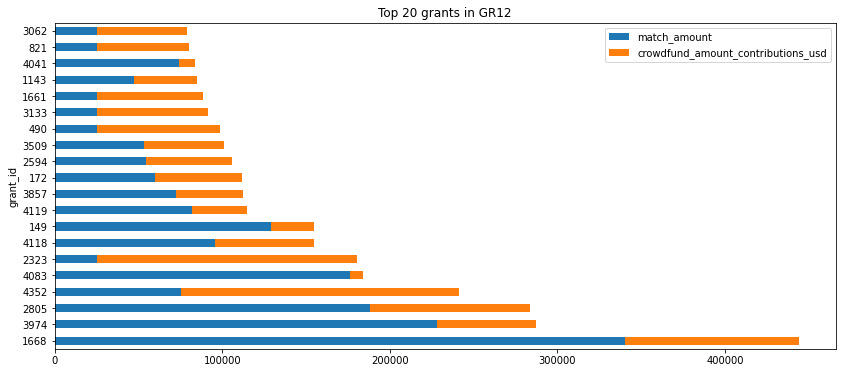

In [23]:
qf_df.sort_values('total', ascending=False).head(20)[
    ['grant_id', 'match_amount', 'crowdfund_amount_contributions_usd']
].plot.barh(
    x='grant_id',
    y=['match_amount', 'crowdfund_amount_contributions_usd'], 
    stacked=True,
    figsize=(14,6),
    title="Top 20 grants in GR12"
)
plt.show()